# Get data

In [1]:
import pandas as pd
creek_weather_data=pd.read_csv('final_creek_and_weather_dataset.csv')
creek_weather_data['datetime']=pd.to_datetime(creek_weather_data['datetime'])
cols_to_drop = ['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Hour', 'Minute','SiteID','capture15','Prog_Sign','Batt_Volt_Avg']
creek_weather_data = creek_weather_data.drop(columns=cols_to_drop, errors='ignore')
creek_weather_data.columns

Index(['datetime', 'conductivity', 'depth', 'temperature', 'location',
       'BaroPres', 'Day_of_Month', 'Day_of_Week', 'DeltaTemp_Avg',
       'Dew_Pt_Avg', 'Month', 'PanelTmpF_Avg', 'RelHum_Avg', 'SigmaTheta',
       'SigmaTheta_res', 'SolRad_Avg', 'Temp_Avg', 'Temp_Max', 'Temp_Min',
       'Temp10m_Avg', 'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max',
       'WindGust_Max', 'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup',
       'WndSpd_res', 'rain_mm'],
      dtype='object')

# plot code

In [2]:
def plot_date_range(df, location, start_date, end_date, spill_event, hours_avg=None):
    # This entire function remains the same and will work correctly
    # as long as the final DataFrame has 'rain_mm' and other expected columns.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    spill_event = pd.to_datetime(spill_event)
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
    plot_df = plot_df.set_index('datetime').sort_index()
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
    span_end = spill_event + pd.Timedelta(days=1)
    ax_temp.axvspan(spill_event, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()


In [3]:
def plot_model_predictions(df, location, start_date, end_date, sensor):
    # Filter the data
    subset = df[
        (df['location'] == location) &
        (df['datetime'] >= start_date) &
        (df['datetime'] <= end_date)
    ].copy().sort_values('datetime')

    # Base line plot for sensor data
    fig = px.line(subset, x='datetime', y=sensor, title=f"{sensor} with Predictions & Spill Events")

    # Prediction markers ("x")
    preds = subset[subset['predicted_event'] == 1]
    fig.add_trace(go.Scatter(
        x=preds['datetime'],
        y=preds[sensor],
        mode='markers',
        marker=dict(symbol='x', color='red', size=8),
        name='Predicted spill'
    ))

    # Shade true spill events
    in_spill = False
    spill_start = None
    for _, row in subset.iterrows():
        if row['true_event'] == 1 and not in_spill:
            in_spill = True
            spill_start = row['datetime']
        elif (row['true_event'] == 0 or pd.isna(row['true_event'])) and in_spill:
            fig.add_vrect(
                x0=spill_start, x1=row['datetime'],
                fillcolor="orange", opacity=0.3, line_width=0
            )
            in_spill = False
    # Close spill if it ends at the last point
    if in_spill:
        fig.add_vrect(
            x0=spill_start, x1=subset['datetime'].iloc[-1],
            fillcolor="orange", opacity=0.3, line_width=0
        )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title=sensor,
        legend_title="Legend",
        hovermode="x unified"
    )

    fig.show()

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Final results visualization
def plot_final_results(results_df, location='footbridge', 
                      start_date='2021-05-10', end_date='2021-05-25'):
    """
    Create a comprehensive plot showing the final model results
    """
    # Filter data for the specific location and date range
    plot_data = results_df[
        (results_df['location'] == location) & 
        (results_df['datetime'] >= start_date) & 
        (results_df['datetime'] <= end_date)
    ].copy().sort_values('datetime')
    
    if plot_data.empty:
        print(f"No data found for {location} between {start_date} and {end_date}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
    fig.suptitle(f'Spill Detection Results - {location.title()}', fontsize=16)
    
    # Plot 1: Conductivity with predictions
    ax1 = axes[0]
    ax1.plot(plot_data['datetime'], plot_data['conductivity'], 
             color='blue', alpha=0.7, label='Conductivity (μS/cm)')
    
    # Mark predictions
    pred_spills = plot_data[plot_data['predicted_event'] == 1]
    if not pred_spills.empty:
        ax1.scatter(pred_spills['datetime'], pred_spills['conductivity'], 
                   color='red', marker='x', s=50, label='Predicted Spill', zorder=5)
    
    # Shade true spill events
    true_spills = plot_data[plot_data['true_event'] == 1]
    if not true_spills.empty:
        for date in true_spills['datetime']:
            ax1.axvline(x=date, color='orange', alpha=0.3, linewidth=2)
    
    ax1.set_ylabel('Conductivity (μS/cm)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Temperature and Depth
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(plot_data['datetime'], plot_data['temperature'], 
                     color='red', alpha=0.7, label='Temperature (°C)')
    line2 = ax2_twin.plot(plot_data['datetime'], plot_data['depth'], 
                          color='green', alpha=0.7, label='Depth (mm)')
    
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax2_twin.set_ylabel('Depth (mm)', color='green')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Rain and Weather
    ax3 = axes[2]
    if 'rain_mm' in plot_data.columns:
        bars = ax3.bar(plot_data['datetime'], plot_data['rain_mm'], 
                       width=0.02, color='purple', alpha=0.6, label='Rain (mm)')
    
    # Add wind speed on secondary axis
    if 'WndSpd' in plot_data.columns:
        ax3_twin = ax3.twinx()
        ax3_twin.plot(plot_data['datetime'], plot_data['WndSpd'], 
                     color='gray', alpha=0.7, label='Wind Speed')
        ax3_twin.set_ylabel('Wind Speed', color='gray')
    
    ax3.set_ylabel('Rain (mm)')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Model Performance Summary
    ax4 = axes[3]
    
    # Create event timeline
    events = []
    colors = []
    for idx, row in plot_data.iterrows():
        if row['true_event'] == 1:
            events.append(1)  # True spill
            colors.append('orange')
        elif row['predicted_event'] == 1:
            events.append(0.5)  # Predicted spill
            colors.append('red')
        else:
            events.append(0)  # Normal
            colors.append('blue')
    
    ax4.scatter(plot_data['datetime'], events, c=colors, alpha=0.6, s=20)
    ax4.set_ylabel('Events')
    ax4.set_yticks([0, 0.5, 1])
    ax4.set_yticklabels(['Normal', 'Predicted', 'True Spill'])
    ax4.grid(True, alpha=0.3)
    
    # Format x-axis
    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot summary statistics
def plot_model_performance_summary(results_df, metrics):
    """
    Create summary plots showing model performance across different metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Performance Summary', fontsize=16)
    
    # Performance metrics bar chart
    ax1 = axes[0, 0]
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    bars = ax1.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    ax1.set_title('Model Performance Metrics')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # Event distribution pie chart
    ax2 = axes[0, 1]
    labeled_data = results_df[results_df['event'] != -1]
    event_counts = labeled_data['event'].value_counts()
    labels = ['Clean (0)', 'Spill (1)']
    colors = ['lightblue', 'orange']
    ax2.pie(event_counts.values, labels=labels, colors=colors, autopct='%1.1f%%')
    ax2.set_title('True Event Distribution')
    
    # Prediction distribution
    ax3 = axes[1, 0]
    pred_counts = labeled_data['predicted_event'].value_counts()
    ax3.pie(pred_counts.values, labels=['Clean (0)', 'Spill (1)'], 
            colors=['lightblue', 'red'], autopct='%1.1f%%')
    ax3.set_title('Predicted Event Distribution')
    
    # Confusion matrix visualization
    ax4 = axes[1, 1]
    y_true = (labeled_data['true_event'] > 0).astype(int)
    y_pred = (labeled_data['predicted_event'] > 0).astype(int)
    
    # Calculate confusion matrix values
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    confusion_matrix = np.array([[tn, fp], [fn, tp]])
    im = ax4.imshow(confusion_matrix, cmap='Blues', alpha=0.7)
    ax4.set_xticks([0, 1])
    ax4.set_yticks([0, 1])
    ax4.set_xticklabels(['Clean', 'Spill'])
    ax4.set_yticklabels(['Clean', 'Spill'])
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('Actual')
    ax4.set_title('Confusion Matrix')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax4.text(j, i, confusion_matrix[i, j],
                          ha="center", va="center", color="black", fontsize=14)
    
    plt.tight_layout()
    plt.show()

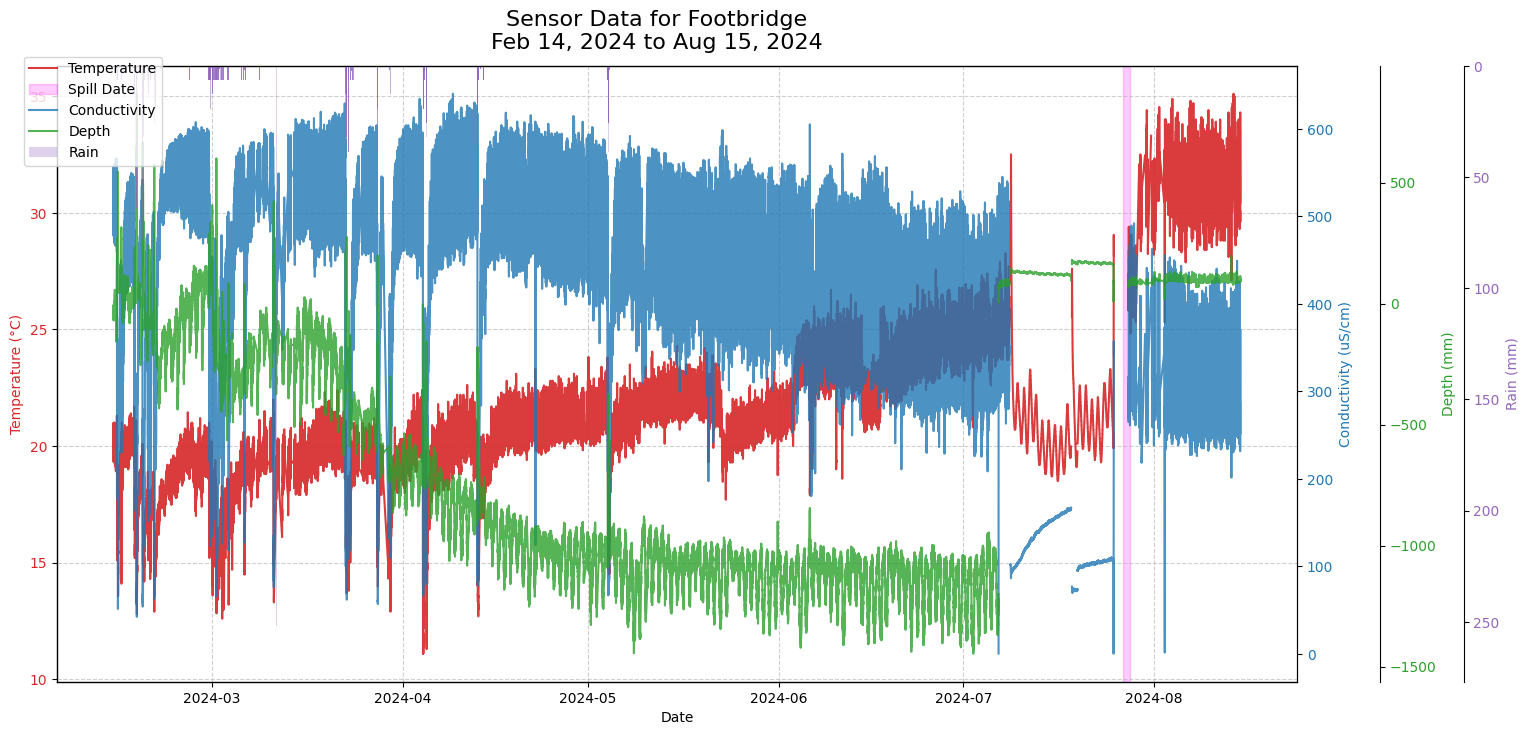

In [5]:
plot_date_range(
    df=creek_weather_data,
    location='footbridge',
    start_date= pd.to_datetime('2024-02-14'),
    end_date= pd.to_datetime('2024-08-15'),# This will create the magenta shaded area
    spill_event =  pd.to_datetime('2024-07-27')
)

# Label Events

In [6]:
import pandas as pd
import numpy as np

def label_events_updated(df, event_windows):
    """
    Labels events in a DataFrame based on multiple time windows with location awareness.
    FIXED: Handles timezone-aware datetime comparisons properly.

    Args:
        df (pd.DataFrame): The input DataFrame, must contain 'datetime' and 'location' columns.
        event_windows (dict): A dictionary where keys are unique event names
                              and values are tuples of (start_time, end_time, sensor_location).

    Returns:
        pd.DataFrame: The original DataFrame with an added 'event' column.
    """
    # Ensure 'datetime' column is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize the 'event' column, defaulting all data to anomaly (-1)
    df['event'] = -1

    # Detect if datetimes are timezone-aware
    is_timezone_aware = df['datetime'].dt.tz is not None
    target_tz = df['datetime'].dt.tz if is_timezone_aware else None
    
    print(f"Data timezone awareness: {is_timezone_aware}")
    if is_timezone_aware:
        print(f"Target timezone: {target_tz}")

    # Process 'clean' windows first
    for event_name, event_data in event_windows.items():
        if 'clean' in event_name:
            # Handle new format (start, end, location)
            if len(event_data) == 3:
                start_str, end_str, location = event_data
            else:
                continue  # Skip old format
                
            # Skip if location not specified
            if location == 'NEED_LOCATION':
                continue
            
            # FIXED: Convert timestamps to match data timezone
            start = pd.to_datetime(start_str)
            end = pd.to_datetime(end_str)
            
            # Localize to match data timezone if needed
            if is_timezone_aware:
                if start.tz is None:
                    start = start.tz_localize(target_tz)
                if end.tz is None:
                    end = end.tz_localize(target_tz)
            
            # Create a boolean mask for the time window AND location
            time_mask = (df['datetime'] >= start) & (df['datetime'] <= end)
            location_mask = (df['location'] == location)
            combined_mask = time_mask & location_mask
            
            df.loc[combined_mask, 'event'] = 0
            print(f"Labeled {combined_mask.sum()} points as clean for {event_name} at {location}")

    # Process 'spill' windows second to ensure they take precedence over clean
    for event_name, event_data in event_windows.items():
        if event_name.startswith('spill'):
            # Handle new format (start, end, location)
            if len(event_data) == 3:
                start_str, end_str, location = event_data
            else:
                continue  # Skip old format
                
            # Skip if location not specified
            if location == 'NEED_LOCATION':
                continue
                
            # FIXED: Convert timestamps to match data timezone
            start = pd.to_datetime(start_str)
            end = pd.to_datetime(end_str)
            
            # Localize to match data timezone if needed
            if is_timezone_aware:
                if start.tz is None:
                    start = start.tz_localize(target_tz)
                if end.tz is None:
                    end = end.tz_localize(target_tz)
            
            # Create a boolean mask for the time window AND location
            time_mask = (df['datetime'] >= start) & (df['datetime'] <= end)
            location_mask = (df['location'] == location)
            combined_mask = time_mask & location_mask
            
            df.loc[combined_mask, 'event'] = 1
            print(f"Labeled {combined_mask.sum()} points as spill for {event_name} at {location}")

    print("\nLocation-aware data labeling complete!")
    print("Value counts for each event type:")
    event_counts = df['event'].value_counts().sort_index()
    print(event_counts)
    
    # Show breakdown by location
    print("\nEvent distribution by location:")
    location_breakdown = df.groupby(['location', 'event']).size().unstack(fill_value=0)
    print(location_breakdown)

    return df

In [7]:
# Test the new location-aware labeling (without spill_4_x for now)
test_event_windows = {
    # Only include events where we've specified locations
    'spill_2': ('2023-06-14 08:00', '2023-06-16 18:00', 'footbridge'),
    'clean_2': ('2023-02-13 00:00', '2023-06-14 00:00', 'footbridge'),
    
    'spill_5': ('2024-07-27 13:15', '2024-08-14 00:00', 'footbridge'),
    'clean_5': ('2024-02-14 00:00', '2024-07-07 00:00', 'footbridge'),
    
    'spill_3_0': ('2025-06-10 16:30', '2025-06-10 18:45', 'south_fork_0'),
    'clean_3_0': ('2025-06-05 00:00', '2025-06-10 00:00', 'south_fork_0'),
    
    'spill_3_1': ('2025-06-11 15:00', '2025-06-11 18:00', 'south_fork_1'),
    'clean_3_1': ('2025-06-03 00:00', '2025-06-09 23:59', 'south_fork_1'),
    
    'spill_3_2': ('2025-06-11 14:45', '2025-06-11 23:30', 'south_fork_2'),
    'clean_3_2': ('2025-06-03 00:00', '2025-06-09 23:59', 'south_fork_2'),

}

print("=== Testing Location-Aware Labeling ===")
merged_labeled_data = label_events_updated(creek_weather_data, test_event_windows)
merged_labeled_data.head(3)

=== Testing Location-Aware Labeling ===
Data timezone awareness: False
Labeled 33294 points as clean for clean_2 at footbridge
Labeled 61204 points as clean for clean_5 at footbridge
Labeled 346 points as clean for clean_3_0 at south_fork_0
Labeled 417 points as clean for clean_3_1 at south_fork_1
Labeled 415 points as clean for clean_3_2 at south_fork_2
Labeled 484 points as spill for spill_2 at footbridge
Labeled 3614 points as spill for spill_5 at footbridge
Labeled 9 points as spill for spill_3_0 at south_fork_0
Labeled 12 points as spill for spill_3_1 at south_fork_1
Labeled 35 points as spill for spill_3_2 at south_fork_2

Location-aware data labeling complete!
Value counts for each event type:
event
-1    379710
 0     95676
 1      4154
Name: count, dtype: int64

Event distribution by location:
event                 -1      0     1
location                             
codornices          9886      0     0
footbridge        308253  94498  4098
kingman_hall         618      0   

,datetime,conductivity,depth,temperature,location,BaroPres,Day_of_Month,Day_of_Week,DeltaTemp_Avg,Dew_Pt_Avg,...,VertWind_Avg,VertWind_Max,WindGust_Max,WndDir,WndDir_res,WndSpd,WndSpd_dup,WndSpd_res,rain_mm,event
0,2021-04-30 21:50:00,0.0,-3.5,24.5,footbridge,986.4019,30,6,-0.873,47.07,...,0.0,0.0,11.68,145.3,146.9,7.394,7.394,7.12,0.0,-1
1,2021-04-30 21:55:00,0.0,-3.3,24.5,footbridge,986.4019,30,6,-0.850,46.95,...,0.0,0.0,13.97,142.3,142.9,9.520,9.520,9.25,0.0,-1
2,2021-04-30 22:00:00,0.0,-3.7,24.5,footbridge,986.4019,30,6,-0.850,46.95,...,0.0,0.0,13.97,142.3,142.9,9.520,9.520,9.25,0.0,-1


# Create Features 

In [8]:
import pandas as pd

def create_features(df, feature_cols, horizon=1, window_sizes=[3, 6, 12, 24, 48],
                    include_location_encoding=True, target_col='conductivity'):
    """
    Engineers comprehensive time-series features for FUTURE prediction.
    
    Uses CURRENT and PAST data as features to predict target_col at time t+horizon.
    
    Args:
        df: Input DataFrame with time-series data
        feature_cols: List of columns to engineer features from
        horizon: Number of time steps into the FUTURE to predict (e.g., 24 = predict 24 hours ahead)
        window_sizes: List of rolling window sizes for feature engineering
        include_location_encoding: Whether to add location one-hot encoding
        target_col: Column to predict in the future
    
    Returns:
        DataFrame with engineered features and target column shifted to future values
    """
    print(f"Creating features to predict '{target_col}' {horizon} steps into the FUTURE...")
    print(f"(Using current/past data at time t to predict value at time t+{horizon})")
    
    df_base = df.sort_values(['location', 'datetime']).reset_index(drop=True)
    feature_frames = [df_base]  # start with base DataFrame

    # Time-series features - ALL based on CURRENT and PAST data
    for col in feature_cols:
        print(f"Processing column: {col}")
        for window in window_sizes:
            grouped = df_base.groupby('location')[col]
            feats = pd.DataFrame(index=df_base.index)

            # Lag & rolling statistics (look backward in time)
            feats[f'{col}_lag_{window}'] = grouped.shift(window).values
            feats[f'{col}_roll_mean_{window}'] = grouped.rolling(window, min_periods=1).mean().values
            feats[f'{col}_roll_std_{window}'] = grouped.rolling(window, min_periods=1).std().values
            feats[f'{col}_sma_{window}'] = feats[f'{col}_roll_mean_{window}']
            feats[f'{col}_ema_{window}'] = grouped.ewm(span=window, adjust=False, min_periods=1).mean().values
            feats[f'{col}_roll_var_{window}'] = grouped.rolling(window, min_periods=1).var().values
            feats[f'{col}_roll_min_{window}'] = grouped.rolling(window, min_periods=1).min().values
            feats[f'{col}_roll_max_{window}'] = grouped.rolling(window, min_periods=1).max().values
            feats[f'{col}_roll_range_{window}'] = (
                grouped.rolling(window, min_periods=1).max()
                - grouped.rolling(window, min_periods=1).min()
            ).values

            # Derivatives (rate of change)
            feats[f'{col}_deriv_1_{window}'] = grouped.diff().shift(window).values
            feats[f'{col}_deriv_2_{window}'] = grouped.diff().diff().shift(window).values
            feats[f'{col}_ema_deriv_{window}'] = grouped.ewm(span=window, adjust=False,
                                                            min_periods=1).mean().diff().values

            # Bollinger-style features (volatility indicators)
            sma_values = grouped.rolling(window, min_periods=1).mean()
            std_values = grouped.rolling(window, min_periods=1).std()
            zscore = grouped.transform(
                lambda g: (g - g.rolling(window, min_periods=1).mean()) /
                          g.rolling(window, min_periods=1).std().replace(0, 1e-8)
            ).fillna(0).values

            feats[f'{col}_zscore_{window}'] = zscore
            feats[f'{col}_upper_band_{window}'] = (sma_values + 2 * std_values).values
            feats[f'{col}_lower_band_{window}'] = (sma_values - 2 * std_values).values

            feature_frames.append(feats)

    # Location one-hot encoding
    if include_location_encoding:
        print("Adding location one-hot encoding...")
        locations = df_base['location'].unique()
        loc_feats = pd.DataFrame({
            f'location_{loc}': (df_base['location'] == loc).astype(int)
            for loc in locations
        })
        feature_frames.append(loc_feats)
        print(f"Added {len(locations)} location encoding features")

    # Concatenate all feature sets at once
    df_features = pd.concat(feature_frames, axis=1)

    # Create FUTURE target (negative shift = look forward)
    if target_col in df_features.columns:
        target_name = f'{target_col}_target'
        print(f"\nCreating target column '{target_name}':")
        print(f"  - At time t, target = {target_col} value at time t+{horizon}")
        print(f"  - Using NEGATIVE shift(-{horizon}) to get FUTURE values")
        
        df_features[target_name] = df_features.groupby('location')[target_col].shift(-horizon).values
        
        # Count how many NaN targets we have (last 'horizon' rows per location)
        n_nan_targets = df_features[target_name].isna().sum()
        print(f"  - Note: Last {horizon} rows per location have NaN targets (no future data available)")
        print(f"  - Total NaN targets: {n_nan_targets}")

    # Diagnostics
    print("\nNaN diagnostic:")
    nan_counts = df_features.isnull().sum()
    high_nan_features = nan_counts[nan_counts > len(df_features) * 0.8]
    if len(high_nan_features) > 0:
        print(f"Features with >80% NaN values: {len(high_nan_features)}")
        print(f"Examples: {list(high_nan_features.head(10).index)}")

    print(f"Total NaN values across all features: {df_features.isnull().sum().sum()}")
    print(f"Rows with any NaN: {df_features.isnull().any(axis=1).sum()}")

    # Summary
    locations = df_base['location'].unique() if include_location_encoding else []
    total_original_features = len(feature_cols)
    features_per_window = 15
    total_time_features = total_original_features * len(window_sizes) * features_per_window
    total_location_features = len(locations) if include_location_encoding else 0

    print("\nEnhanced feature engineering summary:")
    print(f"  - Original features: {len(df.columns)}")
    print(f"  - Time-series features added: {total_time_features}")
    print(f"  - Location encoding features: {total_location_features}")
    print(f"  - Total features: {len(df_features.columns)}")
    print(f"  - Total rows: {len(df_features)}")
    print(f"  - Prediction horizon: {horizon} steps into the future")

    return df_features

# Train Sensor Model

In [11]:
from sklearn.linear_model import Ridge
import xgboost as xgb
import numpy as np
import pandas as pd

def train_sensor_model(df, feature_cols, target_col='conductivity',
                      model_type='xgboost', **model_params):
    """
    Trains a model to predict normal sensor values using only clean data.
    Supports Ridge regression or XGBoost.
    
    Args:
        df: DataFrame with sensor data
        feature_cols: List of feature column names (already includes location encoding if desired)
        target_col: Target column name (default: 'conductivity')
        model_type: 'ridge' or 'xgboost'
        **model_params: Additional parameters for the chosen model
    
    Returns:
        Trained model with metadata
    """
    print(f"Training a {model_type.upper()} model to predict normal '{target_col}' values...")

    # Train ONLY on data labeled as 'clean' (event == 0)
    clean_df = df[df['event'] == 0].copy()

    # Drop rows with missing values in any of the required columns
    clean_df = clean_df.dropna(subset=feature_cols + [target_col])
    
    if len(clean_df) == 0:
        raise ValueError("No clean data available for sensor model training after dropping NaN values!")

    X_train = clean_df[feature_cols]
    y_train = clean_df[target_col]
    
    print(f"Training sensor model on {len(clean_df)} clean data points")

    # Create and train the chosen model
    if model_type.lower() == 'ridge':
        ridge_params = {'alpha': 1.0}
        ridge_params.update(model_params)
        
        sensor_model = Ridge(**ridge_params)
        sensor_model.fit(X_train, y_train)
        print(f"Ridge regression trained with alpha={ridge_params['alpha']}")
        
    elif model_type.lower() == 'xgboost':
        # Default XGBoost parameters optimized for regression
        xgb_params = {
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'objective': 'reg:squarederror'
        }
        xgb_params.update(model_params)
        
        sensor_model = xgb.XGBRegressor(**xgb_params)
        sensor_model.fit(X_train, y_train)
        print(f"XGBoost trained with n_estimators={xgb_params['n_estimators']}, max_depth={xgb_params['max_depth']}")
        
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Choose 'ridge' or 'xgboost'")

    print(f"Sensor prediction model ({model_type}) trained.")
    
    # Store metadata about the model for later use
    sensor_model.feature_cols_ = feature_cols
    sensor_model.model_type_ = model_type
    
    return sensor_model


def predict_with_sensor_model(sensor_model, df, feature_cols):
    """
    Make predictions using the trained sensor model.
    Assumes location encoding was handled upstream (e.g., in create_features).
    """
    df_pred = df.copy()
    model_features = sensor_model.feature_cols_
    predictions = sensor_model.predict(df_pred[model_features])
    return predictions


def calculate_sensor_confidence(df, sensor_model, feature_cols, target_col='conductivity', 
                               percentage_threshold=0.15, k=1.0):
    """
    Calculate sigmoid-based confidence scores for sensor anomaly detection.
    Uses percentage-based thresholds instead of standard deviation-based thresholds.
    """
    predicted_values = predict_with_sensor_model(sensor_model, df, feature_cols)
    error = np.abs(df[target_col] - predicted_values)
    error_std = error.std()
    
    threshold = np.abs(predicted_values) * percentage_threshold
    confidence_scores = 2 / (1 + np.exp(-k * (error - threshold))) - 1
    
    return confidence_scores, threshold, error_std


def add_sensor_confidence_features(df, sensor_model, feature_cols, target_col='conductivity',
                                  percentage_threshold=0.15, k=1.0):
    """
    Add both binary anomaly flag AND continuous confidence score to DataFrame.
    Uses percentage-based thresholds instead of standard deviation-based thresholds.
    """
    confidence_scores, threshold, error_std = calculate_sensor_confidence(
        df, sensor_model, feature_cols, target_col, percentage_threshold, k
    )
    
    predicted_values = predict_with_sensor_model(sensor_model, df, feature_cols)
    raw_error = np.abs(df[target_col] - predicted_values)
    
    df = df.copy()
    df['sensor_confidence'] = confidence_scores
    df['sensor_error'] = raw_error
    df['sensor_anomaly'] = (raw_error > threshold).astype(int)
    
    print(f"Added sensor confidence features using {sensor_model.model_type_.upper()}:")
    print(f"  - sensor_confidence: Range [{confidence_scores.min():.3f}, {confidence_scores.max():.3f}]")
    print(f"  - sensor_error: Range [{raw_error.min():.3f}, {raw_error.max():.3f}]")
    print(f"  - Threshold used: {threshold.mean():.3f} (={percentage_threshold:.1%} of predicted values)")
    print(f"  - Total anomalies: {df['sensor_anomaly'].sum()}/{len(df)} ({100*df['sensor_anomaly'].mean():.1f}%)")
    
    return df


In [12]:
# Define feature columns to engineer
feature_columns = ['conductivity', 'temperature', 'depth', 'BaroPres', 
                   'SolRad_Avg', 'rain_mm', 'Temp2m_Avg', 'WndSpd']

# Create features with 24-hour ahead prediction
featured_df = create_features(
    merged_labeled_data, 
    feature_columns, 
    horizon=5,  # Predict 24 hours into future
    target_col='conductivity'
)

# Define training features - EXCLUDE the target column
train_features = [col for col in featured_df.columns 
                  if col not in ['datetime', 'event', 'location', 'conductivity_target']]

print(f"\nTotal features for training: {len(train_features)}")

# Train model to predict FUTURE conductivity
sensor_model = train_sensor_model(
    featured_df,
    feature_cols=train_features,
    target_col='conductivity_target',  # ← THE KEY CHANGE: predict the future value
    model_type='xgboost',
    n_estimators=200,
    max_depth=5
)

Creating features to predict 'conductivity' 5 steps into the FUTURE...
(Using current/past data at time t to predict value at time t+5)
Processing column: conductivity
Processing column: temperature
Processing column: depth
Processing column: BaroPres
Processing column: SolRad_Avg
Processing column: rain_mm
Processing column: Temp2m_Avg
Processing column: WndSpd
Adding location one-hot encoding...
Added 10 location encoding features

Creating target column 'conductivity_target':
  - At time t, target = conductivity value at time t+5
  - Using NEGATIVE shift(-5) to get FUTURE values
  - Note: Last 5 rows per location have NaN targets (no future data available)
  - Total NaN targets: 6825

NaN diagnostic:
Total NaN values across all features: 1387696
Rows with any NaN: 11102

Enhanced feature engineering summary:
  - Original features: 31
  - Time-series features added: 600
  - Location encoding features: 10
  - Total features: 642
  - Total rows: 479540
  - Prediction horizon: 5 steps i

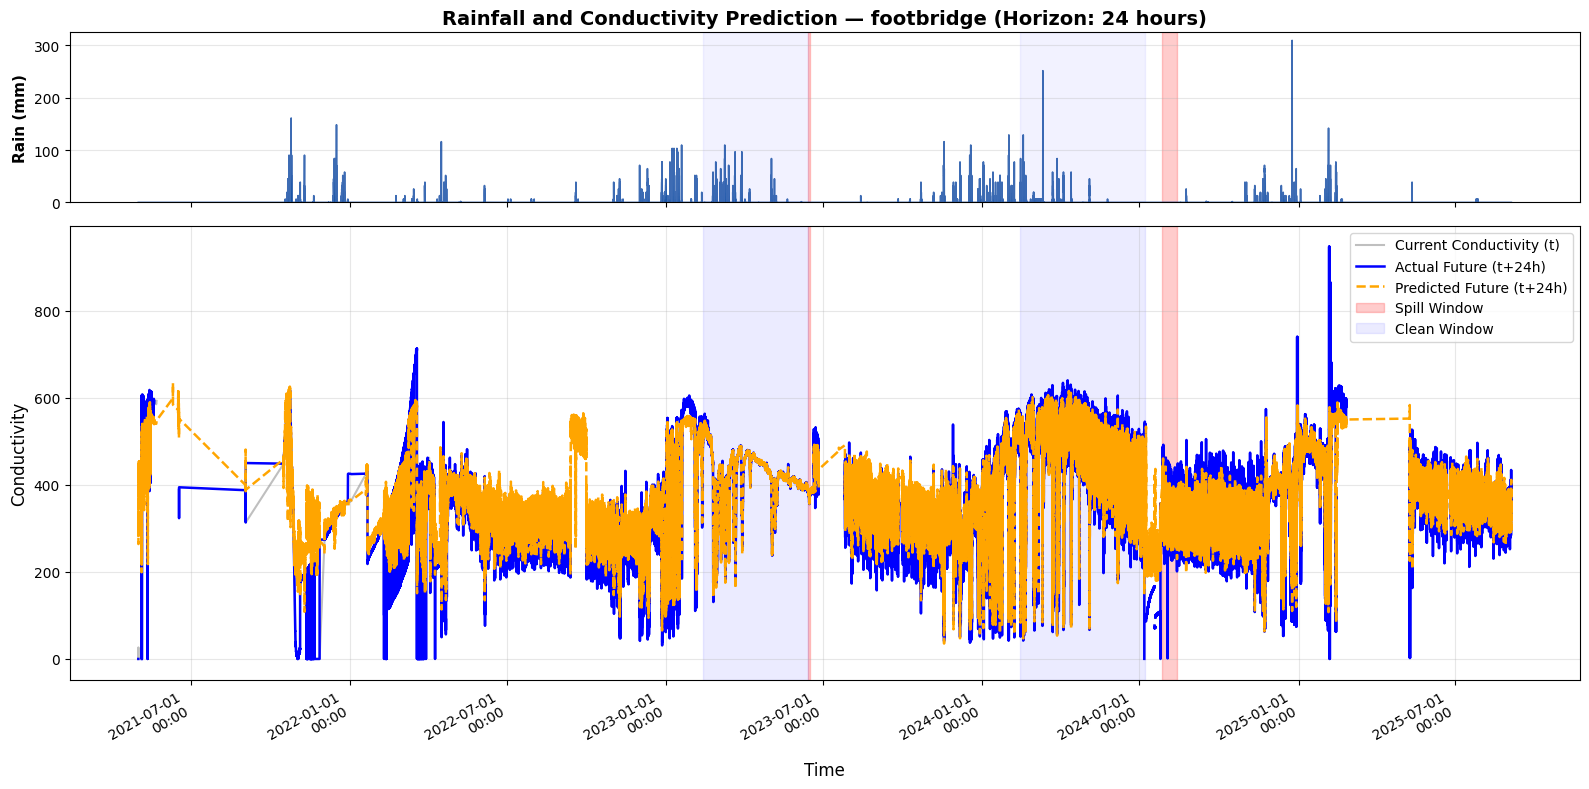


=== Prediction Statistics ===
Location: footbridge
Total data points: 406849
Total rainfall: 259098.84 mm
Max rainfall in single reading: 309.63 mm
Mean Absolute Error (MAE): 40.73
Root Mean Squared Error (RMSE): 66.85
Valid predictions: 400152/406849


In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# --- Define spill and clean windows ---
event_windows = {
    'spill_2': ('2023-06-14 08:00', '2023-06-16 18:00', 'footbridge'),
    'clean_2': ('2023-02-13 00:00', '2023-06-14 00:00', 'footbridge'),
    'spill_5': ('2024-07-27 13:15', '2024-08-14 00:00', 'footbridge'),
    'clean_5': ('2024-02-14 00:00', '2024-07-07 00:00', 'footbridge'),
}

# --- Choose location to plot ---
location_to_plot = 'footbridge'
loc_df = featured_df[featured_df['location'] == location_to_plot].copy()

# --- Get model predictions ---
X_loc = loc_df[train_features]
y_pred = sensor_model.predict(X_loc)
loc_df['predicted_future_conductivity'] = y_pred

# --- Create figure with two subplots ---
fig, (ax_rain, ax_main) = plt.subplots(2, 1, figsize=(16, 8), 
                                        gridspec_kw={'height_ratios': [1.5, 4]},  # Made rain taller
                                        sharex=True)

# --- TOP SUBPLOT: Rain as filled area (darker and more visible) ---
ax_rain.fill_between(loc_df['datetime'], 0, loc_df['rain_mm'], 
                     color='#1f77b4', alpha=0.9, linewidth=0)  # Darker blue, higher alpha
ax_rain.plot(loc_df['datetime'], loc_df['rain_mm'], 
             color='#0d47a1', linewidth=1.2, alpha=0.8)  # Added top line for definition
ax_rain.set_ylabel('Rain (mm)', fontsize=11, fontweight='bold')
ax_rain.set_title(f'Rainfall and Conductivity Prediction — {location_to_plot} (Horizon: 24 hours)', 
                  fontsize=14, fontweight='bold')
ax_rain.grid(True, alpha=0.3, axis='y')
ax_rain.set_ylim(bottom=0)

# --- BOTTOM SUBPLOT: Conductivity ---
# Current actual conductivity (what it is NOW at time t)
ax_main.plot(loc_df['datetime'], loc_df['conductivity'], 
             label='Current Conductivity (t)', 
             color='gray', linewidth=1.5, alpha=0.5, linestyle='-')

# Actual future conductivity (what it WILL BE at time t+horizon)
ax_main.plot(loc_df['datetime'], loc_df['conductivity_target'], 
             label=f'Actual Future (t+{24}h)', 
             color='blue', linewidth=1.8)

# Predicted future conductivity (what we PREDICT it will be at time t+horizon)
ax_main.plot(loc_df['datetime'], loc_df['predicted_future_conductivity'], 
             label=f'Predicted Future (t+{24}h)', 
             color='orange', linewidth=1.8, linestyle='--')

# --- Add shaded spill & clean windows ---
for key, (start_str, end_str, loc) in event_windows.items():
    if loc != location_to_plot:
        continue  # skip events for other locations
    
    start = pd.to_datetime(start_str)
    end = pd.to_datetime(end_str)
    
    if 'spill' in key:
        # Add to both subplots
        ax_rain.axvspan(start, end, color='red', alpha=0.2)
        ax_main.axvspan(start, end, color='red', alpha=0.2, 
                       label='Spill Window' if 'Spill Window' not in ax_main.get_legend_handles_labels()[1] else None)
    elif 'clean' in key:
        # Add to both subplots
        ax_rain.axvspan(start, end, color='blue', alpha=0.05)
        ax_main.axvspan(start, end, color='blue', alpha=0.08, 
                       label='Clean Window' if 'Clean Window' not in ax_main.get_legend_handles_labels()[1] else None)

# Format datetime axis (only on bottom plot since they're shared)
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()

# Labels and legend
ax_main.set_xlabel('Time', fontsize=12)
ax_main.set_ylabel('Conductivity', fontsize=12)
ax_main.legend(loc='best', fontsize=10)
ax_main.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Optional: Print some statistics ---
print("\n=== Prediction Statistics ===")
print(f"Location: {location_to_plot}")
print(f"Total data points: {len(loc_df)}")
print(f"Total rainfall: {loc_df['rain_mm'].sum():.2f} mm")
print(f"Max rainfall in single reading: {loc_df['rain_mm'].max():.2f} mm")

# Calculate error only where we have both actual future and predictions (non-NaN)
valid_mask = loc_df['conductivity_target'].notna()
if valid_mask.sum() > 0:
    mae = np.abs(loc_df.loc[valid_mask, 'conductivity_target'] - 
                 loc_df.loc[valid_mask, 'predicted_future_conductivity']).mean()
    rmse = np.sqrt(((loc_df.loc[valid_mask, 'conductivity_target'] - 
                     loc_df.loc[valid_mask, 'predicted_future_conductivity'])**2).mean())
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Valid predictions: {valid_mask.sum()}/{len(loc_df)}")
else:
    print("No valid predictions available (all NaN targets)")